# Documnent Scanner

In [1]:
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
import imutils

# Image Preprocessing and Edge Detection

In [2]:
def image_preprocess(img):
    image = img.copy()
    ratio = image.shape[0] / 500.0
    image = imutils.resize(image, height = 500)

    # convert the image to grayscale, blur it, and find edges in the image

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    edged = cv2.Canny(gray, 50, 200)

    # show the original image and the edge detected image

    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(1,2,1)
    plt.title("Original Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    
    fig.add_subplot(1,2,2)
    plt.title("Edged Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(edged)
    plt.show()
    
    return image, edged, ratio

# Contours Detection on Canny Image

In [3]:
def contours(image, edged):
    cnts, heirarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    # loop over the contours

    for c in cnts:

        # approximate the contour

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we can assume that we have found our screen

        if len(approx) == 4:
            screenCnt = approx
            break

    # show the contour (outline) of the piece of paper


    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    fig=plt.figure(figsize=(7,7))
    plt.title("Contour Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    
    return screenCnt

# Apply a Perspective Transform & Threshold

In [4]:
def order_points(pts):
    
    # initialzie a list of coordinates that will be ordered  such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the bottom-right, and the fourth is the bottom-left
    
    rect = np.zeros((4, 2), dtype = "float32")
    
    # the top-left point will have the smallest sum, whereas the bottom-right point will have the largest sum
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # now, compute the difference between the points, the top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    # return the ordered coordinates
    
    return rect

In [5]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them individually
    
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
       
    #compute the height of the new image, which will be the maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points in the top-left, top-right, bottom-right, and bottom-left order
    
    dst = np.array([
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]], dtype = "float32")
    
    # compute the perspective transform matrix and then apply it
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    
    return warped

In [6]:
def final_scanned(screenCnt, image, ratio):
    orig = image.copy()
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    # convert the warped image to grayscale, then threshold it to give it that 'black and white' paper effect

    #warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    #T = threshold_local(warped, 11, offset = 10, method = "gaussian")
    #warped = (warped > T).astype("uint8") * 255

    # show the original and scanned images


    #cv2.imshow("Original", imutils.resize(orig, height = 650))
    #cv2.imshow("Scanned", imutils.resize(warped, height = 650))
    #cv2.waitKey(0)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    
    fig=plt.figure(figsize=(15,15))
    fig.add_subplot(1,2,1)
    plt.title("Original Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(orig)
    
    fig.add_subplot(1,2,2)
    plt.title("Scanned Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(warped)
    plt.show()

# Image 1

In [7]:
img = cv2.imread('1.jpg')

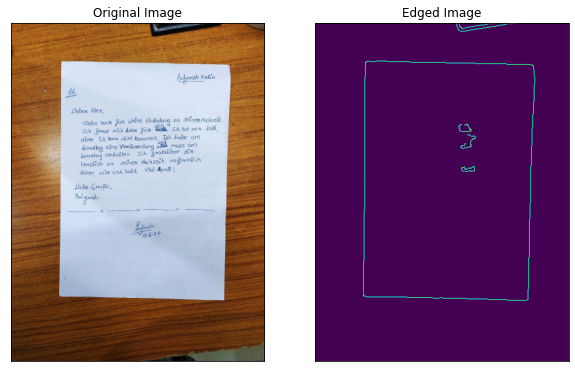

In [8]:
image, edged, ratio = image_preprocess(img)

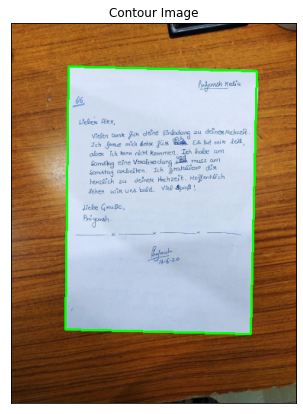

In [9]:
screenCnt = contours(image, edged)

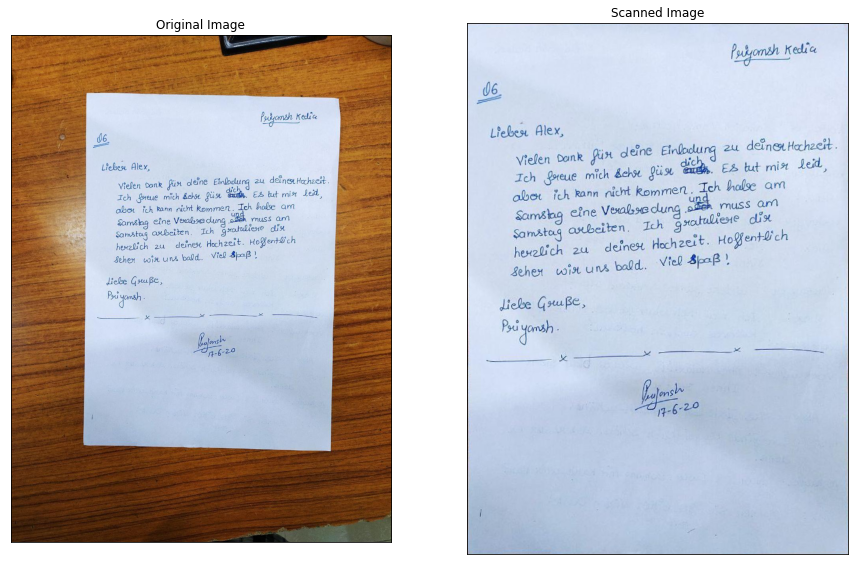

In [10]:
final_scanned(screenCnt, img, ratio)

# Image 2

In [11]:
img = cv2.imread('2.jpg')

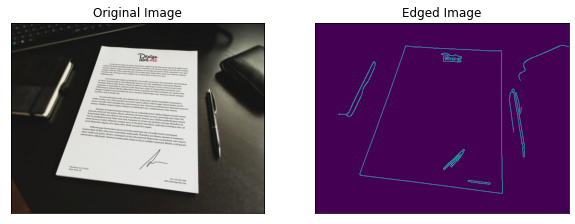

In [12]:
image, edged, ratio = image_preprocess(img)

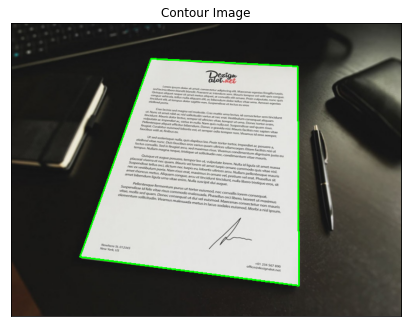

In [13]:
screenCnt = contours(image, edged)

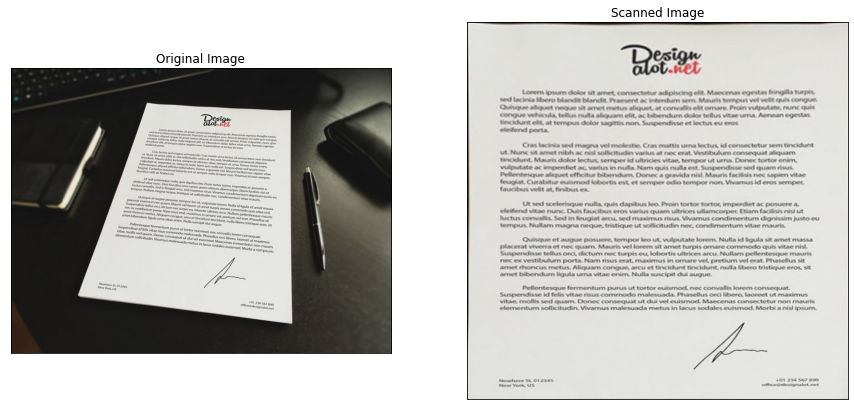

In [14]:
final_scanned(screenCnt, img, ratio)